# Experiment plotting

This notebook contains the code for plotting results for the different experiments.
When run for the first time for a town, condensed summary files are being created which strongly speed up subsequent generations of plots from the same summaries. It is possible to create the plots only from the condensed summaries located in 'summaries/condensed_summaries'.
Note that this works for all experiments but the Rt plots, which still require the full summary file.


In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
import pandas as pd
import pickle
from lib.measures import *
from lib.experiment import Experiment, Plot, Result, get_properties, load_summary_list, load_summary
from lib.data import collect_data_from_df
from lib.calibrationSettings import calibration_lockdown_dates, calibration_start_dates, calibration_mob_paths
from lib.calibrationFunctions import get_calibrated_params, downsample_cases
import lib.plot as lib_plot
from lib.plot import Plotter
# from lib.plot import extract_data_from_summary, load_extracted_data

In [5]:
places = [('GER', 'TU')]

## ROC

Loaded previously extracted data.
-0.010   TP 11.50 FP 573.62  TN  0.00  FN  0.00
0.000   TP 11.50 FP 573.38  TN  0.25  FN  0.00
0.010   TP 11.38 FP 516.88  TN 56.75  FN  0.12
0.020   TP 11.25 FP 494.38  TN 79.25  FN  0.25
0.030   TP 11.25 FP 479.75  TN 93.88  FN  0.25
0.040   TP 11.25 FP 467.62  TN 106.00  FN  0.25
0.050   TP 11.12 FP 457.88  TN 115.75  FN  0.38
0.060   TP 11.12 FP 450.62  TN 123.00  FN  0.38
0.070   TP 11.12 FP 444.50  TN 129.12  FN  0.38
0.080   TP 11.12 FP 437.25  TN 136.38  FN  0.38
0.090   TP 11.00 FP 429.25  TN 144.38  FN  0.50
0.100   TP 11.00 FP 424.25  TN 149.38  FN  0.50
0.110   TP 11.00 FP 418.12  TN 155.50  FN  0.50
0.120   TP 11.00 FP 412.88  TN 160.75  FN  0.50
0.130   TP 11.00 FP 407.75  TN 165.88  FN  0.50
0.140   TP 11.00 FP 403.50  TN 170.12  FN  0.50
0.150   TP 11.00 FP 398.62  TN 175.00  FN  0.50
0.160   TP 11.00 FP 394.38  TN 179.25  FN  0.50
0.170   TP 11.00 FP 388.50  TN 185.12  FN  0.50
0.180   TP 11.00 FP 382.75  TN 190.88  FN  0.50
0.190   TP

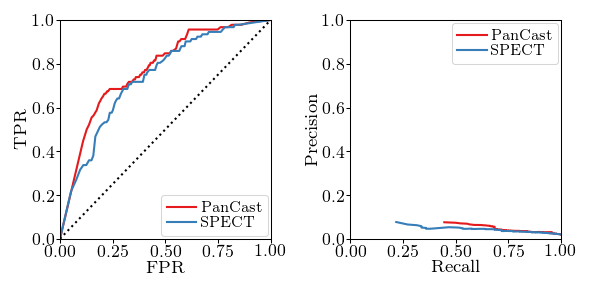

In [19]:
def plot_roc(country, area, p_adoption):
    # Format: {`filename for plot` : `list of `Plot` objects`}
    plots = {
         f'beacon-environment-{country}-{area}' : [
            Plot(label='tracing-stats', 
                path=(f'beacon-environment-{country}-{area}/'
                      f'beacon-environment-{country}-{area}-p_adoption={p_adoption}-x=8.0.pk')),
        ],
    }
    
    for plot_filename, plots in plots.items():
        # extract plot info
        labels = get_properties(plots, 'label')
        paths = get_properties(plots, 'path')
        
#         results = load_summary_list(paths)
#         summaries = get_properties(results, 'summary')
        
    
        # plots
        plotter = Plotter()

        plotter.plot_roc_curve(
            titles=labels,
#             summaries=summaries,
            paths=paths,
            filename=plot_filename, 
            action='isolate',
#             figsize=lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL, 
            figsize=(4, 2), 
            figformat='neurips-double')
        
p_adoption = 1.0
        
for country, area in places:
    plot_roc(country, area, p_adoption)

In [40]:
# Crop pdf margins
# !bash crop_pdfs.sh plots/beacon-environment-*.pdf


# Beacons


In [36]:
country, area = 'CH', 'TI'

In [37]:
def plot_adoption_levels(country, area, ymax):
    # Format: {`filename for plot` : `list of `Plot` objects`}
    plots = {
        f'beacons-compliance-{country}-{area}' : [
            Plot(label='P2P,   50\% compliance',
                path=(f'beacon-baseline-{country}-{area}/'
                      f'beacon-baseline-{country}-{area}-p_adoption=0.5.pk')),
             Plot(label='Beacon, 50\% compliance',
                path=(f'beacon-manual-tracing-{country}-{area}/'
                      f'beacon-manual-tracing-{country}-{area}-p_adoption=0.5-p_recall=1.0-beacon_cache=0.pk')),
            
            Plot(label='P2P,    75\% compiance',
                path=(f'beacon-baseline-{country}-{area}/'
                      f'beacon-baseline-{country}-{area}-p_adoption=0.75.pk')),
            Plot(label='Beacon, 75\% compliance',
                path=(f'beacon-manual-tracing-{country}-{area}/'
                      f'beacon-manual-tracing-{country}-{area}-p_adoption=0.75-p_recall=1.0-beacon_cache=0.pk')),
            
            Plot(label='P2P,    100\% compliance',
                path=(f'beacon-baseline-{country}-{area}/'
                      f'beacon-baseline-{country}-{area}-p_adoption=1.0.pk')),
            Plot(label='Beacon, 100\% compliance',
                path=(f'beacon-manual-tracing-{country}-{area}/'
                      f'beacon-manual-tracing-{country}-{area}-p_adoption=1.0-p_recall=1.0-beacon_cache=0.pk')),
            ]
    }

    for plot_filename, plots in plots.items():

        # extract plot info
        labels = get_properties(plots, 'label')
        paths = get_properties(plots, 'path')

        # plots
        plotter = Plotter()

        plotter.compare_total_infections(
            paths, 
            titles=labels, 
            filename=plot_filename, 
            show_single_runs=False,
#             figsize=lib_plot.FIG_SIZE_FULL_PAGE_TRIPLE_ARXIV, 
            figsize=lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL, 
            figformat='neurips-double',
            legend_is_left=True,
            lockdown_label_y=1000,
            ymax=ymax[country][area],
            x_axis_dates=False,
            xtick_interval=3,
            errorevery=14)

Extracting data from summary: beacon-baseline-CH-TI/beacon-baseline-CH-TI-p_adoption=0.5.pk
Data extraction successful.
Loaded previously extracted data.
Extracting data from summary: beacon-manual-tracing-CH-TI/beacon-manual-tracing-CH-TI-p_adoption=0.5-p_recall=1.0-beacon_cache=0.pk
Data extraction successful.
Loaded previously extracted data.
Extracting data from summary: beacon-baseline-CH-TI/beacon-baseline-CH-TI-p_adoption=0.75.pk
Data extraction successful.
Loaded previously extracted data.
Extracting data from summary: beacon-manual-tracing-CH-TI/beacon-manual-tracing-CH-TI-p_adoption=0.75-p_recall=1.0-beacon_cache=0.pk
Data extraction successful.
Loaded previously extracted data.
Extracting data from summary: beacon-baseline-CH-TI/beacon-baseline-CH-TI-p_adoption=1.0.pk
Data extraction successful.
Loaded previously extracted data.
Extracting data from summary: beacon-manual-tracing-CH-TI/beacon-manual-tracing-CH-TI-p_adoption=1.0-p_recall=1.0-beacon_cache=0.pk
Data extraction 

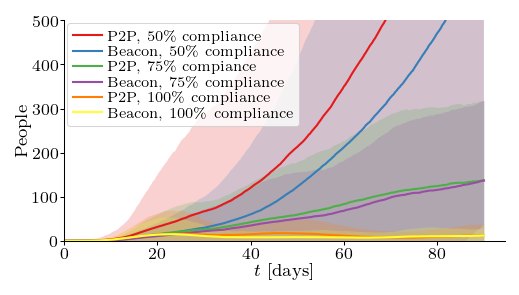

In [38]:
ymax = {'CH' : {'TI': 500, 'BE': 40000, 'JU': 25000},
        'GER': {'TU': 100, 'KL': 2000, 'RH': 3500}}


plot_adoption_levels(country, area, ymax)

In [49]:
def plot_beacon_proportion(country, area, ymax):
    # Format: {`filename for plot` : `list of `Plot` objects`}
    plots = {
        f'beacons-proportion-{country}-{area}' : [
            Plot(label='P2P',
                path=(f'beacon-baseline-{country}-{area}/'
                      f'beacon-baseline-{country}-{area}-p_adoption=0.5.pk')),
            
            Plot(label='Beacon at all sites',
                path=(f'beacon-sparse-locations-{country}-{area}/'
                      f'beacon-sparse-locations-{country}-{area}-p_adoption=0.5-p_recall=1.0-beacon_cache=0.5-beacon_proportion=1.0.pk')),
            Plot(label=r'Beacon at top 80\% sites',
                path=(f'beacon-sparse-locations-{country}-{area}/'
                      f'beacon-sparse-locations-{country}-{area}-p_adoption=0.5-p_recall=1.0-beacon_cache=0.5-beacon_proportion=0.8.pk')),
            Plot(label=r'Beacon at top 50\% sites',
                path=(f'beacon-sparse-locations-{country}-{area}/'
                      f'beacon-sparse-locations-{country}-{area}-p_adoption=0.5-p_recall=1.0-beacon_cache=0.5-beacon_proportion=0.5.pk')),
            Plot(label=r'Beacon at top 10\% sites',
                path=(f'beacon-sparse-locations-{country}-{area}/'
                      f'beacon-sparse-locations-{country}-{area}-p_adoption=0.5-p_recall=1.0-beacon_cache=0.5-beacon_proportion=0.2.pk')),
            ]
    }

    for plot_filename, plots in plots.items():

        # extract plot info
        labels = get_properties(plots, 'label')
        paths = get_properties(plots, 'path')

        # plots
        plotter = Plotter()

        plotter.compare_total_infections(
            paths, 
            titles=labels, 
            filename=plot_filename, 
            show_single_runs=False,
#             figsize=lib_plot.FIG_SIZE_FULL_PAGE_TRIPLE_ARXIV, 
            figsize=lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL, 
            figformat='neurips-double',
            legend_is_left=True,
            lockdown_label_y=1000,
            ymax=ymax[country][area],
            x_axis_dates=False,
            xtick_interval=3,
            errorevery=14)

Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.


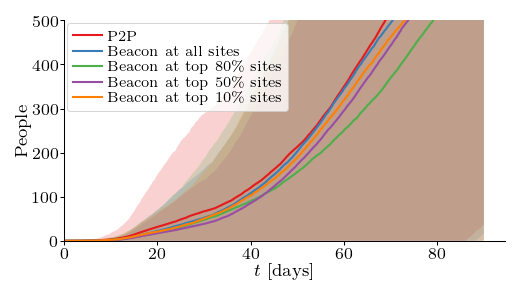

In [50]:
plot_beacon_proportion(country, area, ymax)

In [8]:
def plot_beacon_cache(country, area, ymax):
    # Format: {`filename for plot` : `list of `Plot` objects`}
    plots = {
        f'beacon-cache-{country}-{area}' : [
            Plot(label='P2P',
                path=(f'beacon-baseline-{country}-{area}/'
                      f'beacon-baseline-{country}-{area}-p_adoption=0.5.pk')),
            
            Plot(label='Beacon, cache 0h',
                path=(f'beacon-cache-{country}-{area}/'
                      f'beacon-cache-{country}-{area}-p_adoption=0.5-p_recall=1.0-beacon_cache=0.pk')),
            Plot(label='Beacon, cache 0.5h',
                path=(f'beacon-cache-{country}-{area}/'
                      f'beacon-cache-{country}-{area}-p_adoption=0.5-p_recall=1.0-beacon_cache=0.5.pk')),
            Plot(label='Beacon, cache 1h',
                path=(f'beacon-cache-{country}-{area}/'
                      f'beacon-cache-{country}-{area}-p_adoption=0.5-p_recall=1.0-beacon_cache=1.0.pk')),
            ]
    }

    for plot_filename, plots in plots.items():

        # extract plot info
        labels = get_properties(plots, 'label')
        paths = get_properties(plots, 'path')

        # plots
        plotter = Plotter()

        plotter.compare_total_infections(
            paths, 
            titles=labels, 
            filename=plot_filename, 
            show_single_runs=False,
#             figsize=lib_plot.FIG_SIZE_FULL_PAGE_TRIPLE_ARXIV, 
            figsize=lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL, 
            figformat='neurips-double',
            legend_is_left=True,
            lockdown_label_y=1000,
            ymax=ymax[country][area],
            x_axis_dates=False,
            xtick_interval=3,
            errorevery=14)

In [9]:
plot_beacon_cache(country, area, ymax)

NameError: name 'ymax' is not defined